<a href="https://colab.research.google.com/github/jespimentel/orcamento-sp-webservice/blob/main/sigeo_dotacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install xmltodict

In [4]:
import requests
import xmltodict
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [5]:
def consulta_despesas_dotacao(orgao, ano):
  url = "https://webservices.fazenda.sp.gov.br/WSTransparencia/TransparenciaServico.asmx?op=ConsultarDespesasDotacao"
  headers = {'Content-Type': 'text/xml'}

  # Define o corpo da requisição SOAP
  body = """<?xml version=\"1.0\" encoding=\"utf-8\"?>\n
            <soap:Envelope xmlns:xsi=\"http://www.w3.org/2001/XMLSchema-instance\" xmlns:xsd=\"http://www.w3.org/2001/XMLSchema\" xmlns:soap=\"http://schemas.xmlsoap.org/soap/envelope/\">\n
            <soap:Body>\n
      <ConsultarDespesasDotacao xmlns="http://fazenda.sp.gov.br/wstransparencia">\n
        <ano>ANO</ano>\n
        <codigoOrgao>CODIGO_ORGAO</codigoOrgao>\n
        <codigoUo>Detalhado</codigoUo>\n
        <codigoUnidadeGestora>Detalhado</codigoUnidadeGestora>\n
        <codigoFonteRecursos>Detalhado</codigoFonteRecursos>\n
        <flagDotacaoInicial>1</flagDotacaoInicial>\n
        <flagDotacaoAtual>1</flagDotacaoAtual>\n
        <flagEmpenhado>1</flagEmpenhado>\n
        <flagLiquidado>1</flagLiquidado>\n
        <flagPago>1</flagPago>
      </ConsultarDespesasDotacao>\n
    </soap:Body>\n
  </soap:Envelope>"""

  # Substitui os placeholders (SEU_USUARIO, SUA_SENHA, ANO, etc.) pelos valores reais
  body = body.replace("ANO", str(ano))  # Exemplo com o ano atual
  body = body.replace("CODIGO_ORGAO", orgao)

  # Envia a requisição POST
  response = requests.post(url, headers=headers, data=body, verify=False)

  # Verifica o status da requisição
  if response.status_code == 200:
      print(f"Requisição para ano {ano}: Cód. {response.status_code}")
  else:
      print(f"Erro na requisição para o ano {ano}: {response.status_code}")

  return response.content

In [6]:
# orgaos = ['27000', '03000', '40000', '42000']
orgaos = ['Detalhado']
anos = [2010, 2024]

df_geral = pd.DataFrame()

for orgao in orgaos:
    print(f"Verificando órgão: {orgao}")
    for ano in range (anos[0], anos[1]+1):
      consulta = consulta_despesas_dotacao(orgao, str(ano))
      data = xmltodict.parse(consulta)
      despesas_dotacao = data['soap:Envelope']['soap:Body']['ConsultarDespesasDotacaoResponse']['ConsultarDespesasDotacaoResult']['ListaItensDespesa']['ItemDespesa']
      for item in despesas_dotacao:
        item['Ano'] = str(ano)
      df = pd.DataFrame(despesas_dotacao)


      # Eliminação das linhas de totalização
      df['CodigoNomeOrgao'].replace('', np.nan, inplace=True)
      df.dropna(subset = ['CodigoNomeOrgao'], inplace=True)

      df_geral = pd.concat([df_geral, df], axis=0)

print('Concluído!')

Verificando órgão: Detalhado
Requisição para ano 2010: Cód. 200
Requisição para ano 2011: Cód. 200
Requisição para ano 2012: Cód. 200
Requisição para ano 2013: Cód. 200
Requisição para ano 2014: Cód. 200
Requisição para ano 2015: Cód. 200
Requisição para ano 2016: Cód. 200
Requisição para ano 2017: Cód. 200
Requisição para ano 2018: Cód. 200
Requisição para ano 2019: Cód. 200
Requisição para ano 2020: Cód. 200
Requisição para ano 2021: Cód. 200
Requisição para ano 2022: Cód. 200
Requisição para ano 2023: Cód. 200
Requisição para ano 2024: Cód. 200
Concluído!


In [7]:
colunas = ['Ano', 'CodigoNomeOrgao', 'CodigoNomeUo', 'CodigoNomeUg', 'CodigoNomeFonteRecursos',
           'CodigoNomeElemento', 'ValorDotacaoInicial', 'ValorDotacaoAtual', 'ValorEmpenhado',
           'ValorLiquidado', 'ValorPago', 'ValorPagoAnosAnteriores']

df_geral = df_geral[colunas]

# Substitui os pontos por nada e substitua as vírgulas por ponto
colunas_com_valores = ['ValorDotacaoInicial', 'ValorDotacaoAtual', 'ValorEmpenhado', 'ValorLiquidado',
                       'ValorPago', 'ValorPagoAnosAnteriores']

for coluna in colunas_com_valores:
  df_geral[coluna] = df_geral[coluna].str.replace('.', '').str.replace(',', '.')

# Converte as colunas para o tipo float e arredonde para duas casas decimais
pd.options.display.float_format = '{:.2f}'.format
df_geral[colunas_com_valores] = df_geral[colunas_com_valores].astype(float)

df_geral['Pago Total'] = df_geral['ValorPago'] + df_geral['ValorPagoAnosAnteriores']
df_geral.sample(10)

,Ano,CodigoNomeOrgao,CodigoNomeUo,CodigoNomeUg,CodigoNomeFonteRecursos,CodigoNomeElemento,ValorDotacaoInicial,ValorDotacaoAtual,ValorEmpenhado,ValorLiquidado,ValorPago,ValorPagoAnosAnteriores,Pago Total
5277,2012,09000 - SECRETARIA DA SAUDE,09006 - COORD. DE SERVICOS DE SAUDE,090015 - COORDENADORIA DE SERVICOS DE SAUDE,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,449052 - EQUIPAMENTOS E MATERIAL PERMANENTE,67415000.00,528.55,0.00,0.00,0.00,0.00,0.00
5070,2010,09000 - SECRETARIA DA SAUDE,09045 - FUND.PARA O REM.POPULAR CHOPIN T.LIMA-...,091102 - FUND.P/REM.POPULAR-CHOPIN T. DE LIMA-...,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,449052 - EQUIPAMENTOS E MATERIAL PERMANENTE,0.00,0.00,0.00,0.00,0.00,101785.60,101785.60
5617,2013,09000 - SECRETARIA DA SAUDE,09047 - FUNDACAO PRO-SANGUE HEMOCENTRO DE SAO ...,091301 - FUND. PRO-SANGUE HEMOCENTRO SP.,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,319011 - VENCIMENTOS E VANTAGENS FIXAS-PESSOAL...,18695000.00,18589000.00,18589000.00,18589000.00,17564875.81,1997477.89,19562353.70
9603,2017,20000 - SECRETARIA DA FAZENDA,20002 - COORDENADORIA DA ADMINISTRACAO TRIBUTA...,200169 - REPRESENTACAO FISCAL DE SAO PAULO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,319113 - OBRIGACOES PATRONAIS,0.00,608435.92,608435.92,608435.92,608435.92,0.00,608435.92
6622,2022,10000 - SECR. DESENV. ECONOMICO,10061 - UNIVERSIDADE EST PAUL.JULIO MESQ.FILHO...,"102301 - UNIV.EST.PAULISTA, JULIO MESQUITA FILHO",044 - REC.PROP.ADM.IND-CRED.P/SUPERVAVIT FINAN...,"339037 - SERVICOS DE LIMPEZA,VIGIL.E OUTROS-PE...",0.00,1530.00,1530.00,1530.00,1530.00,0.00,1530.00
5930,2017,13000 - SECRETARIA DE AGRICULTURA E ABASTECIMENTO,13014 - COORDENADORIA DE DEFESA AGROPECUARIA,130198 - ESC. DEF. AGROP. LIMEIRA,003 - RECURSOS VINCULADOS-FUNDO ESPECIAL DE DE...,339092 - DESPESAS DE EXERCICIOS ANTERIORES,0.00,2535.84,2535.84,2535.84,2535.84,0.00,2535.84
8558,2015,18000 - SECRETARIA DA SEGURANCA PUBLICA,18002 - POLICIA CIVIL DO ESTADO DE SAO PAULO,180301 - DELEG.SECC.POLICIA DE ASSIS,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,339046 - AUXILIO ALIMENTACAO,0.00,292840.00,292600.00,292600.00,292360.00,25180.00,317540.00
15506,2018,39000 - SECRETARIA DE SANEAMENTO E RECURSOS HI...,39055 - DEPTO.DE AGUAS E ENERGIA ELETRICA-DAEE,392101 - DEPTO.AGUAS E ENERGIA ELETRICA-DAEE,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,339036 - OUTROS SERVICOS DE TERCEIROS-PESSOA F...,142016.00,127815.00,117152.00,117152.00,117152.00,0.00,117152.00
2855,2021,08000 - SECRETARIA DA EDUCACAO,08001 - ADMINISTRACAO SUPERIOR SECRETARIA E SEDE,080340 - DIR.ENS.-REG.SAO ROQUE,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,339049 - AUXILIO TRANSPORTE,0.00,1101522.77,1101522.77,1101522.77,962300.94,56236.81,1018537.75
12702,2010,38000 - SECRETARIA ADMINISTRACAO PENITENCIARIA,38003 - COORD.UNID.PRISIONAIS REG.MRTROPOLITAN...,"380174 - CDP-ASP VANDA RITA BRITO DO REGO, OSASCO",003 - RECURSOS VINCULADOS-FUNDO ESPECIAL DE DE...,449052 - EQUIPAMENTOS E MATERIAL PERMANENTE,0.00,8550.00,5063.22,5063.22,5063.22,0.00,5063.22


In [8]:
df_geral.to_csv(f'despesas_dotacao_{str(anos[0])}_{str(anos[1])}.csv', index=False)

In [9]:
nome_orgaos = df_geral['CodigoNomeOrgao'].unique().tolist()
nome_orgaos

['01000 - ASSEMBLEIA LEGISLATIVA',
 '02000 - TRIBUNAL DE CONTAS DO ESTADO',
 '03000 - TRIBUNAL DE JUSTICA',
 '06000 - TRIBUNAL DE JUSTICA MILITAR',
 '08000 - SECRETARIA DA EDUCACAO',
 '09000 - SECRETARIA DA SAUDE',
 '10000 - SEC.DESENV. ECONOMICO, CIENCIA,TECN. INOVACA',
 '12000 - SECRETARIA DA CULTURA',
 '13000 - SECRETARIA DE AGRICULTURA E ABASTECIMENTO',
 '16000 - SECRETARIA DE LOGISTICA E TRANSPORTES',
 '17000 - SEC.DA JUSTICA E DA DEFESA DA CIDADANIA',
 '18000 - SECRETARIA DA SEGURANCA PUBLICA',
 '20000 - SECRETARIA DA FAZENDA',
 '21000 - ADMINISTRACAO GERAL DO ESTADO',
 '23000 - SEC.DO EMPREGO E RELACOES DO TRABALHO',
 '25000 - SECRETARIA DA HABITACAO',
 '26000 - SECRETARIA DO MEIO AMBIENTE',
 '27000 - MINISTERIO PUBLICO',
 '28000 - CASA CIVIL',
 '29000 - SECRETARIA DE PLANEJAMENTO E GESTAO',
 '35000 - SECRETARIA DE DESENVOLVIMENTO SOCIAL',
 '37000 - SECRETARIA DOS TRANSPORTES METROPOLITANOS',
 '38000 - SECRETARIA ADMINISTRACAO PENITENCIARIA',
 '39000 - SECRETARIA DE SANEAMENTO E

In [10]:
sp = df_geral.groupby(['Ano'])[['ValorDotacaoInicial', 'ValorDotacaoAtual']].sum()

criterio = (df_geral['CodigoNomeOrgao']== '27000 - MINISTERIO PUBLICO')
mp = df_geral[criterio].groupby(['Ano'])[['ValorDotacaoInicial', 'ValorDotacaoAtual']].sum()

criterio = (df_geral['CodigoNomeOrgao']== '03000 - TRIBUNAL DE JUSTICA')
tj = df_geral[criterio].groupby(['Ano'])[['ValorDotacaoInicial', 'ValorDotacaoAtual']].sum()

In [11]:
sp

,ValorDotacaoInicial,ValorDotacaoAtual
Ano,,
2010,140424395728.00,155085671393.00
2011,155550876867.00,167103004270.79
2012,174067877300.00,180720954083.00
2013,192844281051.00,204306907960.00
2014,212191448179.00,220374909438.00
2015,231048119160.00,237912292356.26
2016,234109593851.00,240440660186.00
2017,234228294909.00,241881335034.00
2018,245925840704.00,253892403730.00


In [12]:
mp

,ValorDotacaoInicial,ValorDotacaoAtual
Ano,,
2010,1290098232.00,1337085158.00
2011,1384202015.00,1467590239.00
2012,1532278218.00,1557090261.00
2013,1635342715.00,1702435596.00
2014,1745585515.00,1816113455.00
2015,1881159046.00,2097562032.00
2016,2085839267.00,2212516481.00
2017,2305181990.00,2397089845.00
2018,2420576349.00,2617698765.00


In [13]:
tj

,ValorDotacaoInicial,ValorDotacaoAtual
Ano,,
2010,5176147300.00,5510629203.00
2011,5680049427.00,6428244539.00
2012,6875359102.00,7862752570.00
2013,7637105974.00,8791448144.00
2014,8427298492.00,9536497137.00
2015,9477317592.00,10555657592.00
2016,10067423277.00,10973125277.00
2017,10774473877.00,12149113070.00
2018,11666448408.00,12591425796.00


In [14]:
df_1 = pd.concat([sp, mp, tj], axis=1)
df_1.columns = ['SP - Dot Inicial', 'SP - Dot Atual', 'MP - Dot Inicial', 'MP - Dot Atual', 'TJ - Dot Inicial', 'TJ - Dot Atual']
df_1

,SP - Dot Inicial,SP - Dot Atual,MP - Dot Inicial,MP - Dot Atual,TJ - Dot Inicial,TJ - Dot Atual
Ano,,,,,,
2010,140424395728.00,155085671393.00,1290098232.00,1337085158.00,5176147300.00,5510629203.00
2011,155550876867.00,167103004270.79,1384202015.00,1467590239.00,5680049427.00,6428244539.00
2012,174067877300.00,180720954083.00,1532278218.00,1557090261.00,6875359102.00,7862752570.00
2013,192844281051.00,204306907960.00,1635342715.00,1702435596.00,7637105974.00,8791448144.00
2014,212191448179.00,220374909438.00,1745585515.00,1816113455.00,8427298492.00,9536497137.00
2015,231048119160.00,237912292356.26,1881159046.00,2097562032.00,9477317592.00,10555657592.00
2016,234109593851.00,240440660186.00,2085839267.00,2212516481.00,10067423277.00,10973125277.00
2017,234228294909.00,241881335034.00,2305181990.00,2397089845.00,10774473877.00,12149113070.00
2018,245925840704.00,253892403730.00,2420576349.00,2617698765.00,11666448408.00,12591425796.00


In [15]:
pd.options.display.float_format = '{:.4f}'.format
df_1['MP Dot Inicial %'] = df_1['MP - Dot Inicial']/df_1['SP - Dot Inicial']*100
df_1['MP Dot Atual %'] = df_1['MP - Dot Atual']/df_1['SP - Dot Atual']*100
df_1['TJ Dot Inicial %'] = df_1['TJ - Dot Inicial']/df_1['SP - Dot Inicial']*100
df_1['TJ Dot Atual %'] = df_1['TJ - Dot Atual']/df_1['SP - Dot Atual']*100
df_1

,SP - Dot Inicial,SP - Dot Atual,MP - Dot Inicial,MP - Dot Atual,TJ - Dot Inicial,TJ - Dot Atual,MP Dot Inicial %,MP Dot Atual %,TJ Dot Inicial %,TJ Dot Atual %
Ano,,,,,,,,,,
2010,140424395728.0000,155085671393.0000,1290098232.0000,1337085158.0000,5176147300.0000,5510629203.0000,0.9187,0.8622,3.6861,3.5533
2011,155550876867.0000,167103004270.7900,1384202015.0000,1467590239.0000,5680049427.0000,6428244539.0000,0.8899,0.8783,3.6516,3.8469
2012,174067877300.0000,180720954083.0000,1532278218.0000,1557090261.0000,6875359102.0000,7862752570.0000,0.8803,0.8616,3.9498,4.3508
2013,192844281051.0000,204306907960.0000,1635342715.0000,1702435596.0000,7637105974.0000,8791448144.0000,0.8480,0.8333,3.9602,4.3031
2014,212191448179.0000,220374909438.0000,1745585515.0000,1816113455.0000,8427298492.0000,9536497137.0000,0.8226,0.8241,3.9716,4.3274
2015,231048119160.0000,237912292356.2600,1881159046.0000,2097562032.0000,9477317592.0000,10555657592.0000,0.8142,0.8817,4.1019,4.4368
2016,234109593851.0000,240440660186.0000,2085839267.0000,2212516481.0000,10067423277.0000,10973125277.0000,0.8910,0.9202,4.3003,4.5638
2017,234228294909.0000,241881335034.0000,2305181990.0000,2397089845.0000,10774473877.0000,12149113070.0000,0.9842,0.9910,4.6000,5.0228
2018,245925840704.0000,253892403730.0000,2420576349.0000,2617698765.0000,11666448408.0000,12591425796.0000,0.9843,1.0310,4.7439,4.9594


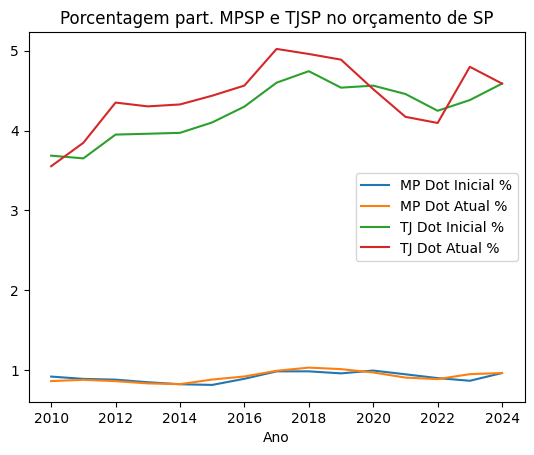

In [16]:
df_1[['MP Dot Inicial %', 'MP Dot Atual %', 'TJ Dot Inicial %','TJ Dot Atual %']].plot()
plt.title('Porcentagem part. MPSP e TJSP no orçamento de SP')
plt.show()

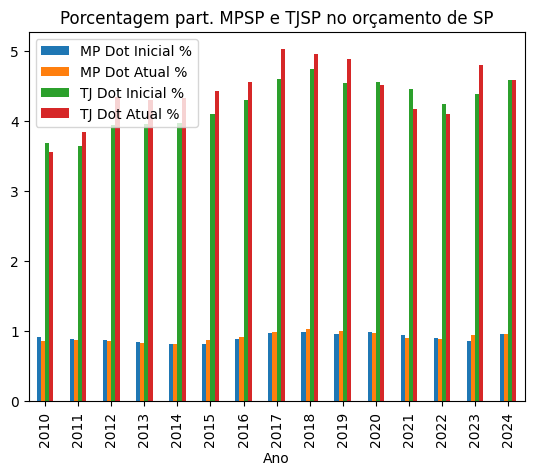

In [17]:
df_1[['MP Dot Inicial %', 'MP Dot Atual %', 'TJ Dot Inicial %','TJ Dot Atual %']].plot.bar()
plt.title('Porcentagem part. MPSP e TJSP no orçamento de SP')
plt.show()

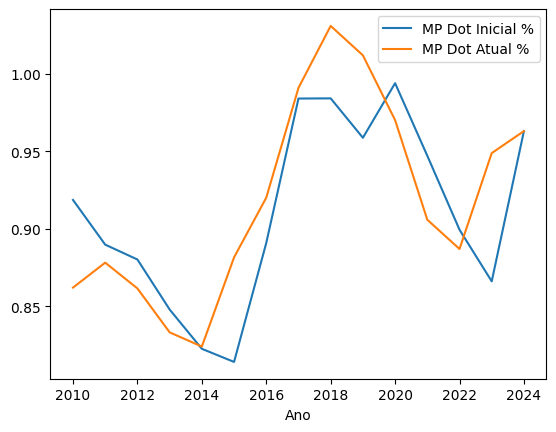

In [18]:
df_1[['MP Dot Inicial %', 'MP Dot Atual %']].plot()
plt.savefig('mp_e_estado.jpg')
plt.show()

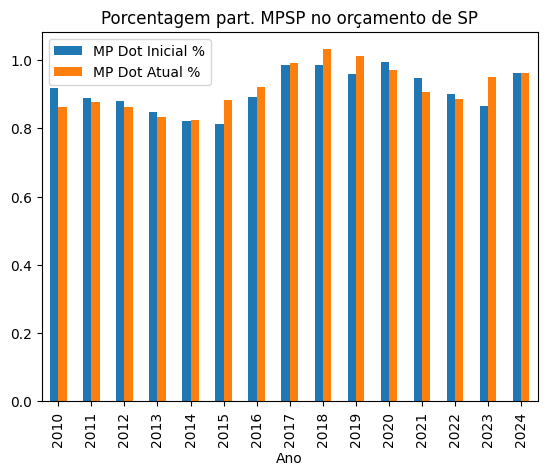

In [19]:
df_1[['MP Dot Inicial %', 'MP Dot Atual %']].plot.bar()
plt.savefig('mp_e_estado_bar.jpg')
plt.title('Porcentagem part. MPSP no orçamento de SP')
plt.show()

In [20]:
criterio = (df_geral['CodigoNomeOrgao']== '27000 - MINISTERIO PUBLICO')
df_mp = df_geral[criterio]
df_mp.head(5)

,Ano,CodigoNomeOrgao,CodigoNomeUo,CodigoNomeUg,CodigoNomeFonteRecursos,CodigoNomeElemento,ValorDotacaoInicial,ValorDotacaoAtual,ValorEmpenhado,ValorLiquidado,ValorPago,ValorPagoAnosAnteriores,Pago Total
11500,2010,27000 - MINISTERIO PUBLICO,27001 - MINISTERIO PUBLICO,270010 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,"319001 - APOSEN.DO RPPS,RESER.RENUM.E REF.DO M...",43588497.0000,727655.9700,0.0000,0.0000,0.0000,0.0000,0.0000
11501,2010,27000 - MINISTERIO PUBLICO,27001 - MINISTERIO PUBLICO,270010 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,319011 - VENCIMENTOS E VANTAGENS FIXAS-PESSOAL...,955109072.0000,1257733.1500,0.0000,0.0000,0.0000,0.0000,0.0000
11502,2010,27000 - MINISTERIO PUBLICO,27001 - MINISTERIO PUBLICO,270010 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,319013 - OBRIGACOES PATRONAIS,3555493.0000,162923.5000,0.0000,0.0000,0.0000,0.0000,0.0000
11503,2010,27000 - MINISTERIO PUBLICO,27001 - MINISTERIO PUBLICO,270010 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,319049 - AUXILIO TRANSPORTE,2556741.0000,48510.1600,0.0000,0.0000,0.0000,0.0000,0.0000
11504,2010,27000 - MINISTERIO PUBLICO,27001 - MINISTERIO PUBLICO,270010 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,319113 - OBRIGACOES PATRONAIS,190037277.0000,1689822.3300,0.0000,0.0000,0.0000,0.0000,0.0000


In [21]:
df_mp['CodigoNomeElemento'].unique().tolist()

['319001 - APOSEN.DO RPPS,RESER.RENUM.E REF.DO MILITAR',
 '319011 - VENCIMENTOS E VANTAGENS FIXAS-PESSOAL CIVIL',
 '319013 - OBRIGACOES PATRONAIS',
 '319049 - AUXILIO TRANSPORTE',
 '319113 - OBRIGACOES PATRONAIS',
 '339008 - OUTROS BENEFICIOS ASSISTENCIAIS',
 '339014 - DIARIAS-CIVIL',
 '339030 - MATERIAL DE CONSUMO',
 '339033 - PASSAGENS E DESPESAS COM LOCOMOCAO',
 '339036 - OUTROS SERVICOS DE TERCEIROS-PESSOA FISICA',
 '339037 - SERVICOS DE LIMPEZA,VIGIL.E OUTROS-PES.JURID',
 '339039 - OUTROS SERVICOS DE TERCEIROS-PESSOA JURIDICA',
 '339046 - AUXILIO ALIMENTACAO',
 '339047 - OBRIGACOES TRIBUTARIAS E CONTRIBUTIVAS',
 '339050 - SERVICOS DE UTILIDADE PUBLICA',
 '339139 - OUT SERV DE TERC-PJ INTRA ORCAMENTARIAS',
 '449051 - OBRAS E INSTALACOES',
 '449052 - EQUIPAMENTOS E MATERIAL PERMANENTE',
 '339092 - DESPESAS DE EXERCICIOS ANTERIORES',
 '339093 - INDENIZACOES E RESTITUICOES',
 '339035 - SERVICOS DE CONSULTORIA',
 '459061 - AQUISICAO DE IMOVEIS',
 '319094 - INDENIZACOES E RESTITUICOES T

In [22]:
criterio = df_mp['CodigoNomeElemento']=='319011 - VENCIMENTOS E VANTAGENS FIXAS-PESSOAL CIVIL'
df_mp_vencimentos = df_mp[criterio].groupby(['Ano', 'CodigoNomeUg'])['Pago Total'].sum()
df_mp_vencimentos

Ano   CodigoNomeUg                            
2010  270010 - MINISTERIO PUBLICO                         0.0000
      270101 - GAB.PROCURADOR GERAL DE JUSTICA    819502096.8600
      270102 - DIRETORIA GERAL                    132881610.1100
2011  270010 - MINISTERIO PUBLICO                         0.0000
      270101 - GAB.PROCURADOR GERAL DE JUSTICA    822308479.1900
      270102 - DIRETORIA GERAL                    186971582.4500
2012  270010 - MINISTERIO PUBLICO                         0.0000
      270101 - GAB.PROCURADOR GERAL DE JUSTICA    881351273.6900
      270102 - DIRETORIA GERAL                    219768116.4900
2013  270010 - MINISTERIO PUBLICO                         0.0000
      270101 - GAB.PROCURADOR GERAL DE JUSTICA    751088446.1600
      270102 - DIRETORIA GERAL                    229609090.4500
2014  270010 - MINISTERIO PUBLICO                         0.0000
      270101 - GAB.PROCURADOR GERAL DE JUSTICA    892318995.2500
      270102 - DIRETORIA GERAL             

In [23]:
pd.options.display.float_format = '{:.2f}'.format
df_mp_vencimentos_1 = df_mp_vencimentos.to_frame().pivot_table(values='Pago Total', index='Ano', columns='CodigoNomeUg', aggfunc=sum).fillna(0)
df_mp_vencimentos_1

CodigoNomeUg,270010 - MINISTERIO PUBLICO,270033 - FED-MINISTERIO PUBLICO,270101 - GAB.PROCURADOR GERAL DE JUSTICA,270102 - DIRETORIA GERAL
Ano,,,,
2010,0.00,0.00,819502096.86,132881610.11
2011,0.00,0.00,822308479.19,186971582.45
2012,0.00,0.00,881351273.69,219768116.49
2013,0.00,0.00,751088446.16,229609090.45
2014,0.00,0.00,892318995.25,268886030.68
2015,0.00,0.00,912670430.66,283883601.64
2016,0.00,2000000.00,1034060827.75,360506740.87
2017,0.00,26281934.80,960371888.34,430165607.61
2018,0.00,0.00,1039089540.21,526008335.95


In [24]:
df_mp_vencimentos_1 = df_mp_vencimentos_1[['270033 - FED-MINISTERIO PUBLICO','270101 - GAB.PROCURADOR GERAL DE JUSTICA', '270102 - DIRETORIA GERAL']]
df_mp_vencimentos_1

CodigoNomeUg,270033 - FED-MINISTERIO PUBLICO,270101 - GAB.PROCURADOR GERAL DE JUSTICA,270102 - DIRETORIA GERAL
Ano,,,
2010,0.00,819502096.86,132881610.11
2011,0.00,822308479.19,186971582.45
2012,0.00,881351273.69,219768116.49
2013,0.00,751088446.16,229609090.45
2014,0.00,892318995.25,268886030.68
2015,0.00,912670430.66,283883601.64
2016,2000000.00,1034060827.75,360506740.87
2017,26281934.80,960371888.34,430165607.61
2018,0.00,1039089540.21,526008335.95


<Figure size 1000x600 with 0 Axes>

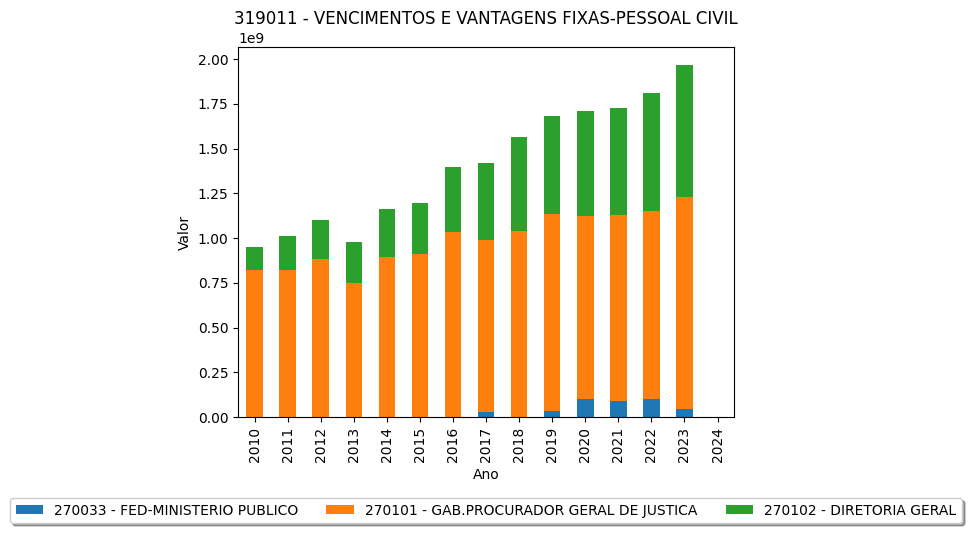

In [25]:
# Plotar
plt.figure(figsize=(10, 6))
ax = df_mp_vencimentos_1.plot(kind='bar', stacked=True)
plt.title('319011 - VENCIMENTOS E VANTAGENS FIXAS-PESSOAL CIVIL')
plt.xlabel('Ano')
plt.ylabel('Valor')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=3)
plt.savefig('vencimentos.jpg')
plt.show()